Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 02-January-2026

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# General settings 
data_dir = r'../Data/'
sampling_rate = 300 # Hz
stimulus_duration = 1 # s

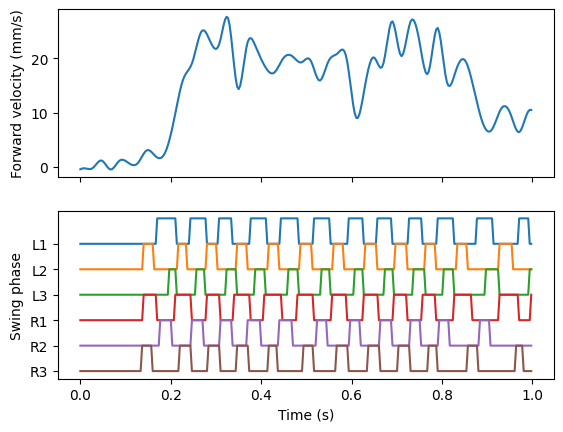

In [3]:
# Plot swing phases of a specific trial

# Settings
dataset = "treadmill_rrn_cschrimson_walking_initiation.csv"
animal_id = 3
trial = 4

# Load data
df = pd.read_csv(data_dir+dataset) 
df_sub = df[(df.animal_id==animal_id) & (df.trial==trial)]

# Find stimulus onset
stimulus = df_sub.stimulus.to_numpy()
stimulus_onset = np.argwhere(np.diff(stimulus) > 0.5) + 1 
stimulus_onset = int(stimulus_onset[0][0])
stimulus_offset = stimulus_onset + stimulus_duration*sampling_rate

time = df_sub.time.to_numpy()
time = time-time[stimulus_onset]

# Plot swing phases 
fig, axs = plt.subplots(2, 1, sharex="all")
axs[0].plot(time[stimulus_onset:stimulus_offset], df_sub.forward_velocity[stimulus_onset:stimulus_offset])
axs[0].set_ylabel('Forward velocity (mm/s)')

axs[1].plot(time[stimulus_onset:stimulus_offset], df_sub.swing_L1[stimulus_onset:stimulus_offset]+5)
axs[1].plot(time[stimulus_onset:stimulus_offset], df_sub.swing_L2[stimulus_onset:stimulus_offset]+4)
axs[1].plot(time[stimulus_onset:stimulus_offset], df_sub.swing_L3[stimulus_onset:stimulus_offset]+3)
axs[1].plot(time[stimulus_onset:stimulus_offset], df_sub.swing_R1[stimulus_onset:stimulus_offset]+2)
axs[1].plot(time[stimulus_onset:stimulus_offset], df_sub.swing_R2[stimulus_onset:stimulus_offset]+1)
axs[1].plot(time[stimulus_onset:stimulus_offset], df_sub.swing_R3[stimulus_onset:stimulus_offset])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Swing phase')
axs[1].set_yticks(range(6), ['R3','R2','R1','L3','L2','L1'])
plt.show()

In [4]:
# Compute latency and probability of swing phases  

# Settings
dataset = "treadmill_rrn_cschrimson_walking_initiation.csv"
parameters = ['swing_L1','swing_L2','swing_L3','swing_R1','swing_R2','swing_R3']
wiggle_room = 1 # Frames
bin_width = 30 # Frames
bins = np.linspace(0,300,int(sampling_rate/bin_width)+1) # Frames

# Load data
df = pd.read_csv(data_dir+dataset) 

# Initialize variables
animal_ids = df.animal_id.unique().tolist()
latencies = np.zeros((len(animal_ids), len(parameters)))
latencies_sorted = np.zeros((len(animal_ids), len(parameters)))
swing_prob = np.zeros((len(animal_ids), 3))
swing_prob_T1 = np.zeros((len(animal_ids), len(bins)-1))
swing_prob_T2 = np.zeros((len(animal_ids), len(bins)-1))
swing_prob_T3 = np.zeros((len(animal_ids), len(bins)-1))
if 'control' in dataset:
    optogenetics = False
else:
    optogenetics = True
    
# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):

    # Initialize variables
    trials_animal = df.trial[df.animal_id == animal_id].unique().tolist()
    latencies_animal = np.zeros((len(trials_animal),len(parameters))) 
    latencies_sorted_animal = np.zeros((len(trials_animal),len(parameters))) 
    swing_prob_animal = np.zeros(3) 
    
    print('Animal ' + str(animal_id) + ': ' + str(len(trials_animal)) + ' trials')

    # Loop over trials
    for trial_index, trial in enumerate(trials_animal):
        df_sub = df[(df.animal_id == animal_id) & (df.trial == trial)]
        
        # Find stimulus onset
        if optogenetics:
            stimulus = df_sub.stimulus.to_numpy()
        else:
            stimulus = df_sub.walking.to_numpy()
            
        stimulus_onset = np.argwhere(np.diff(stimulus) > 0.1) + 1 
        stimulus_onset = int(stimulus_onset[0][0])

        # Compute latencies to swing onsets 
        for parameter_index, parameter in enumerate(parameters):
            # Find first swing onset after stimulus
            swing = df_sub[parameter].to_numpy()
            swing_onsets = np.argwhere(np.diff(swing) > 0) + 1 
            first_swing_onset = int(swing_onsets[swing_onsets > stimulus_onset][0])

            # Compute time delay in ms
            latencies_animal[trial_index][parameter_index] = first_swing_onset - stimulus_onset # 1000 / sampling_rate * (first_swing_onset - stimulus_onset)

        # For spontaneous walking, subtract onset of first swing phase
        if not optogenetics:
            latencies_animal[trial_index][:] = latencies_animal[trial_index][:] - np.min(latencies_animal[trial_index][:])                

        # Determine whether a front, middle, or hind leg moved first
        min_latency = np.min(latencies_animal[trial_index][:])
        #first_leg_indices = np.where(latencies_animal[trial_index] == min_latency)[0]
        first_leg_indices = np.where(latencies_animal[trial_index] <= min_latency + wiggle_room)[0]
                
        # If multiple legs swing at the same time, first_leg_index will have multiple entries 
        if any(np.isin(first_leg_indices, np.array([0,3]))):
            swing_prob_animal[0] += 1
        if any(np.isin(first_leg_indices, np.array([1,4]))):
            swing_prob_animal[1] += 1
        if any(np.isin(first_leg_indices, np.array([2,5]))):
            swing_prob_animal[2] += 1

    # Sort latencies in ascending order 
    latencies_sorted_animal = latencies_animal.copy()
    latencies_sorted_animal.sort()
        
    # Average latencies across trials
    latencies[animal_id_index] = np.mean(latencies_sorted_animal,axis=0)    

    # Compute swing probability across trials 
    swing_prob[animal_id_index][:] = swing_prob_animal / np.sum(swing_prob_animal)

    # Compute probability of a front, middle, or hind leg starting to swing as a function of time
    leg_pairs = [[0,3], [1,4], [2,5]]
    for leg_pair_index, leg_pair in enumerate(leg_pairs):
        counts, _ = np.histogram(np.min(latencies_animal[:][:,leg_pair],axis=1), bins = bins)
        counts = counts/np.sum(counts)
        if leg_pair_index == 0:
            swing_prob_T1[animal_id_index] = counts
        elif leg_pair_index == 1:
            swing_prob_T2[animal_id_index] = counts
        else:
            swing_prob_T3[animal_id_index] = counts

Animal 3: 7 trials
Animal 4: 3 trials
Animal 5: 5 trials
Animal 6: 4 trials
Animal 8: 3 trials
Animal 10: 8 trials
Animal 13: 5 trials
Animal 15: 6 trials
Animal 16: 8 trials


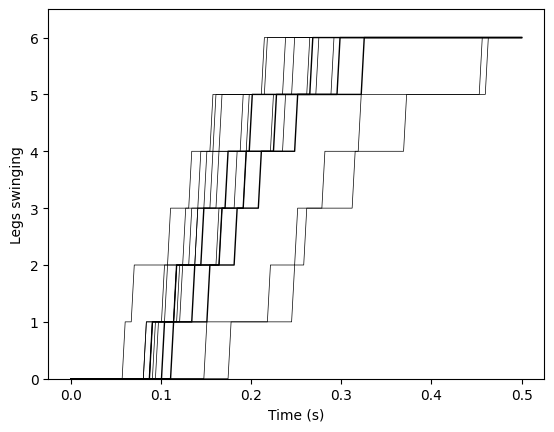

In [5]:
# Plot latencies
duration = 0.5
data_to_plot = np.zeros((len(animal_ids), int(duration*sampling_rate)))
time = np.linspace(0, 1/sampling_rate * (duration*sampling_rate), int(duration*sampling_rate))

for animal_id_index, _ in enumerate(animal_ids):
    for onset in latencies[animal_id_index]: 
        data_to_plot[animal_id_index][int(onset):] += 1
    
    plt.plot(time, data_to_plot[animal_id_index], color=[0,0,0], linewidth=0.5) 

# Compute mean of means
mean_latencies = np.round(np.mean(latencies,axis=0))
mean_data_to_plot = np.zeros((1, int(duration*sampling_rate)))
for onset in mean_latencies: 
    mean_data_to_plot[0][int(onset):] += 1

# Compute sem of means
sem_latencies = np.std(latencies,axis=0) / np.sqrt(len(animal_ids))
lower_sem = mean_latencies-sem_latencies
upper_sem = mean_latencies+sem_latencies
lower_sem_data_to_plot = np.zeros((1, int(duration*sampling_rate)))
upper_sem_data_to_plot = np.zeros((1, int(duration*sampling_rate)))
for onset in lower_sem: 
    lower_sem_data_to_plot[0][int(onset):] += 1
for onset in upper_sem: 
    upper_sem_data_to_plot[0][int(onset):] += 1
    
plt.plot(time, mean_data_to_plot[0], color=[0,0,0], linewidth=1)
plt.plot(time, lower_sem_data_to_plot[0], color=[0,0,0], linewidth=1)
plt.plot(time, upper_sem_data_to_plot[0], color=[0,0,0], linewidth=1)
plt.ylim([0,6.5])
plt.xlabel('Time (s)')
plt.ylabel('Legs swinging')
#plt.savefig(r'C:/Users/Chris/Desktop/figure.eps')
plt.show()

In [22]:
# Display mean latency and sem to first swing in ms
print(str(round(int(mean_latencies[0]) * 1000/sampling_rate)) + ' +- ' + str(round(int(sem_latencies[0]) * 1000/sampling_rate))) 

103 +- 10


In [23]:
# Display mean latency and sem to last swing in ms
print(str(round(int(mean_latencies[5]) * 1000/sampling_rate)) + ' +- ' + str(round(int(sem_latencies[5]) * 1000/sampling_rate))) 

297 +- 27


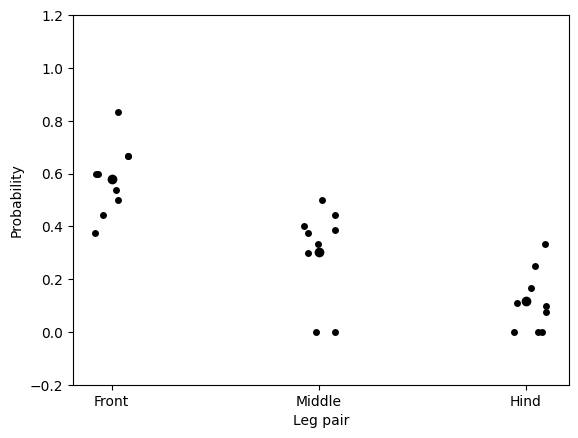

In [6]:
# Plot probability of legs to swing first
sns.stripplot(swing_prob, color=[0,0,0])
plt.plot(np.mean(swing_prob, axis=0), 'o', color=[0,0,0])
plt.ylim([-0.2,1.2])
plt.xlabel('Leg pair')
plt.ylabel('Probability')
ax = plt.gca()
ax.set_xticks(ticks=[0,1,2], labels=['Front','Middle','Hind'])
#plt.savefig(r'C:/Users/Chris/Desktop/figure.eps')
plt.show()